# Stable Diffusion Model Application

In [1]:
from diffusers import DiffusionPipeline

#from optimum.onnxruntime import ORTStableDiffusionXLPipeline
#from optimum.onnxruntime import ORTStableDiffusionXLImg2ImgPipeline

import torch

/home/skim/.pyenv/versions/sd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "stabilityai/stable-diffusion-xl-base-1.0"
base = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

#base = ORTStableDiffusionXLPipeline.from_pretrained(model_id, export=False, provider="CUDAExecutionProvider")

base.unet = torch.compile(base.unet, mode="reduce-overhead", fullgraph=True)
#base.to("cuda")
base.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]


In [3]:
model_id = "stabilityai/stable-diffusion-xl-refiner-1.0"
refiner = DiffusionPipeline.from_pretrained(
    model_id,
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
#refiner.to("cuda")
#refiner = ORTStableDiffusionXLImg2ImgPipeline(model_id, export=True, provider="CUDAExecutionProvider")
refiner.unet = torch.compile(refiner.unet, mode="reduce-overhead", fullgraph=True)
refiner.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.56it/s]


In [4]:
# Define how many steps and what % of steps to be run on each experts (80/20) here
n_steps = 40
high_noise_frac = 0.8

prompt = "A majestic lion jumping from a big stone at night"

In [5]:
# run both experts
image = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=image,
).images[0]

100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:02<00:00,  7.76s/it]


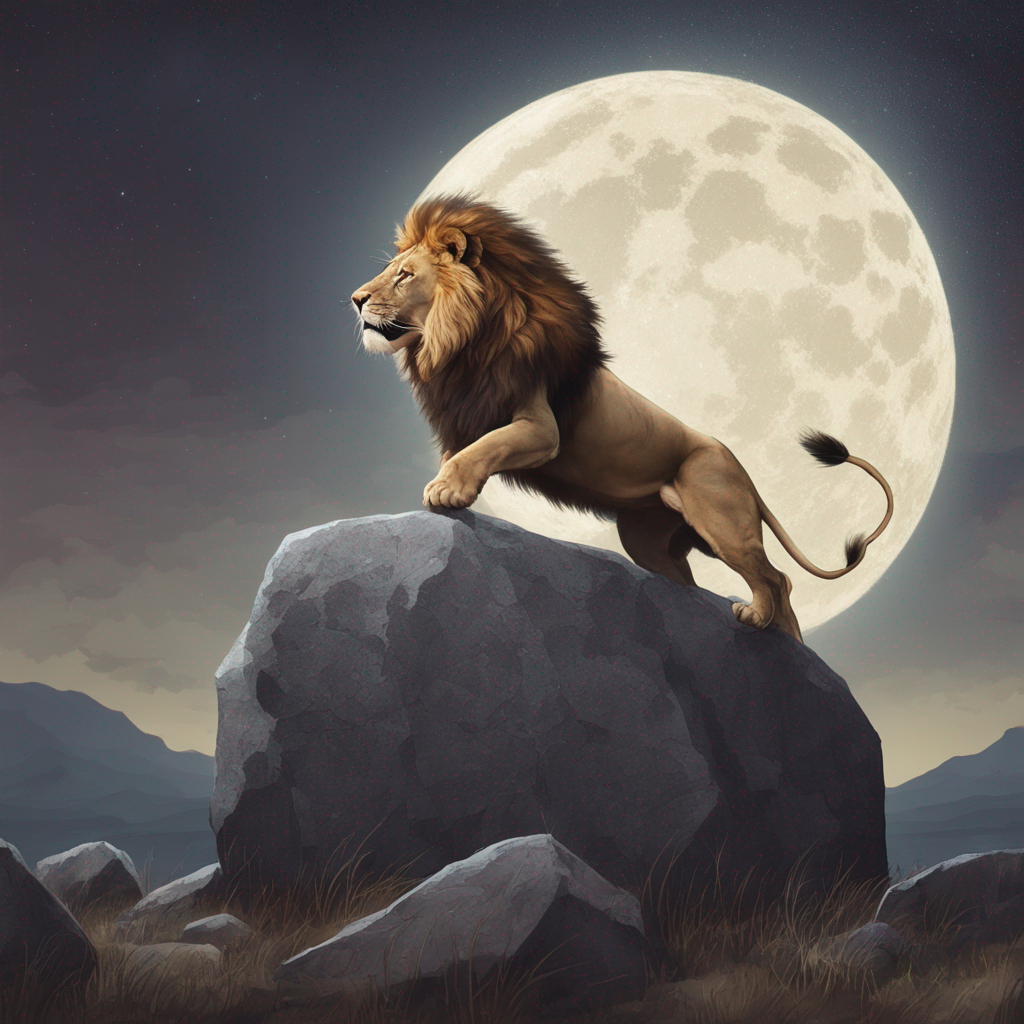

In [6]:
image

100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:53<00:00,  6.68s/it]


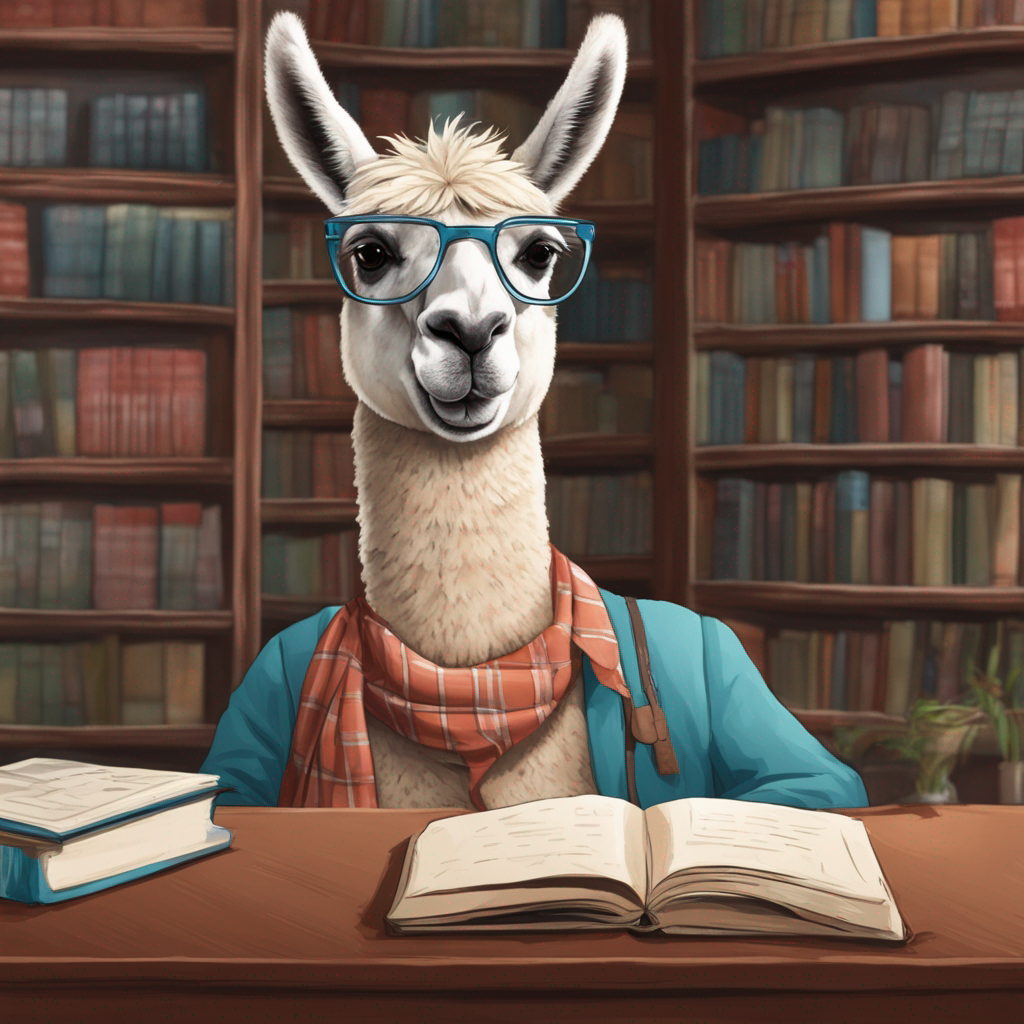

In [5]:
prompt = "A intelligent llama wearing a glass to teach english in a library"

# run both experts
image = base(prompt=prompt, num_inference_steps=n_steps, denoising_end=high_noise_frac, output_type="latent").images
image = refiner(prompt=prompt, num_inference_steps=n_steps, denoising_start=high_noise_frac, image=image).images[0]
image

In [3]:
prompt = "An astronaut riding a green horse"

images = pipe(prompt=prompt).images[0]

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s]


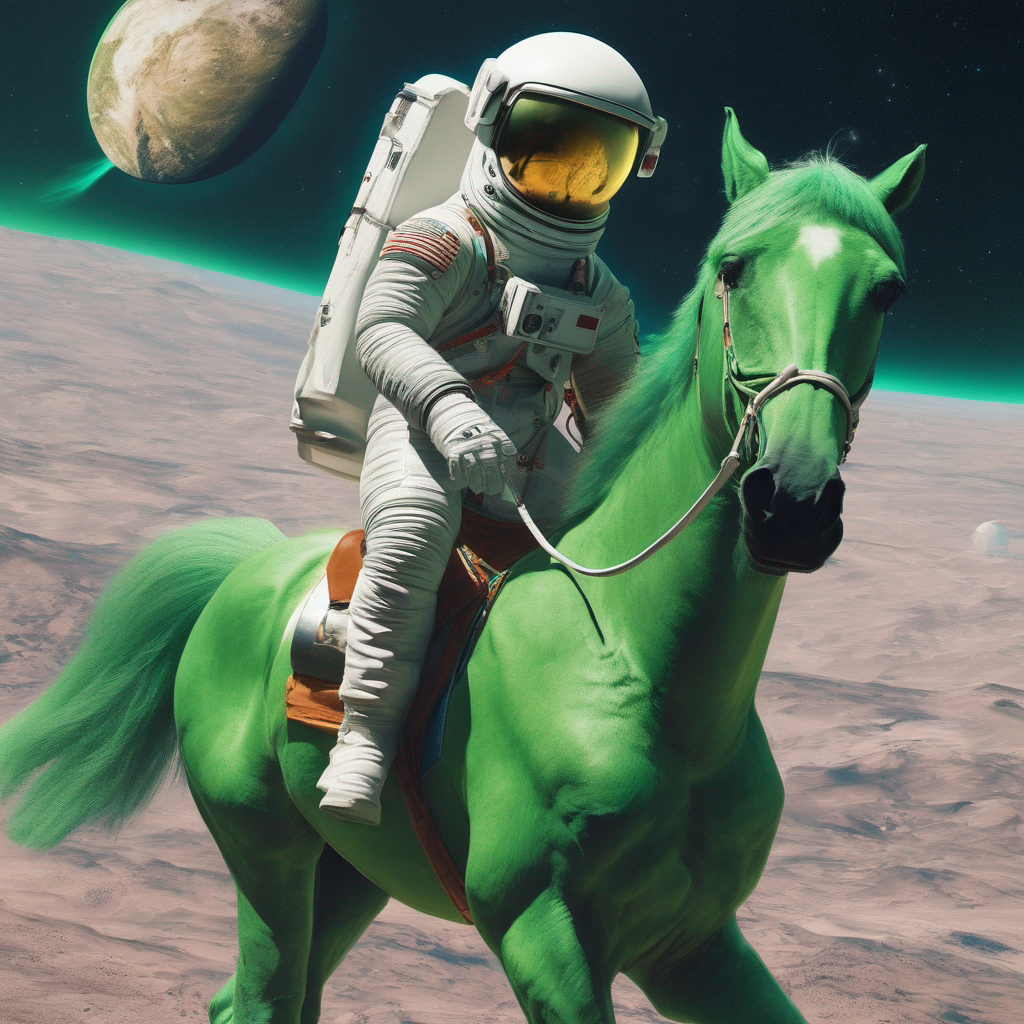

In [4]:
images